<a href="https://colab.research.google.com/github/AnastasiiaVoll/ML/blob/main/Spatial_econometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Analyse and visualise the raw data

In [ ]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import os

In [ ]:
print(os.getcwd())

/content


In [ ]:
# Read the Excel file
df = pd.read_excel("NL_unemployment.xlsx")

In [ ]:
# Sort the DataFrame by year and province
df = df.sort_values(by=["Year", "Province"])

In [ ]:
# Show the first 20 rows of the data
print(df.head(20))

         Province  Year  Regiol Unemployment  National Unemployment
2         Drenthe  1950                  8.7                    2.8
4       Flevoland  1950                  NaN                    2.8
1       Friesland  1950                  4.3                    2.8
5      Gelderland  1950                  2.7                    2.8
0       Groningen  1950                  4.3                    2.8
11        Limburg  1950                  1.8                    2.8
10  Noord-Brabant  1950                  3.6                    2.8
7   Noord-Holland  1950                  2.4                    2.8
3      Overijssel  1950                  1.5                    2.8
6         Utrecht  1950                  2.1                    2.8
9         Zeeland  1950                  2.6                    2.8
8    Zuid-Holland  1950                  2.4                    2.8
14        Drenthe  1951                  8.7                    3.2
16      Flevoland  1951                  NaN    

In [ ]:
print(df.columns)

Index(['Province', 'Year', 'Regiol Unemployment', 'National Unemployment'], dtype='object')


In [ ]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
Province                  0
Year                      0
Regiol Unemployment      23
National Unemployment     0
dtype: int64


In [ ]:
#Checking the data types
print(df.dtypes)

Province                  object
Year                       int64
Regiol Unemployment      float64
National Unemployment    float64
dtype: object


<ipython-input-361-c3bc46572f0e>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


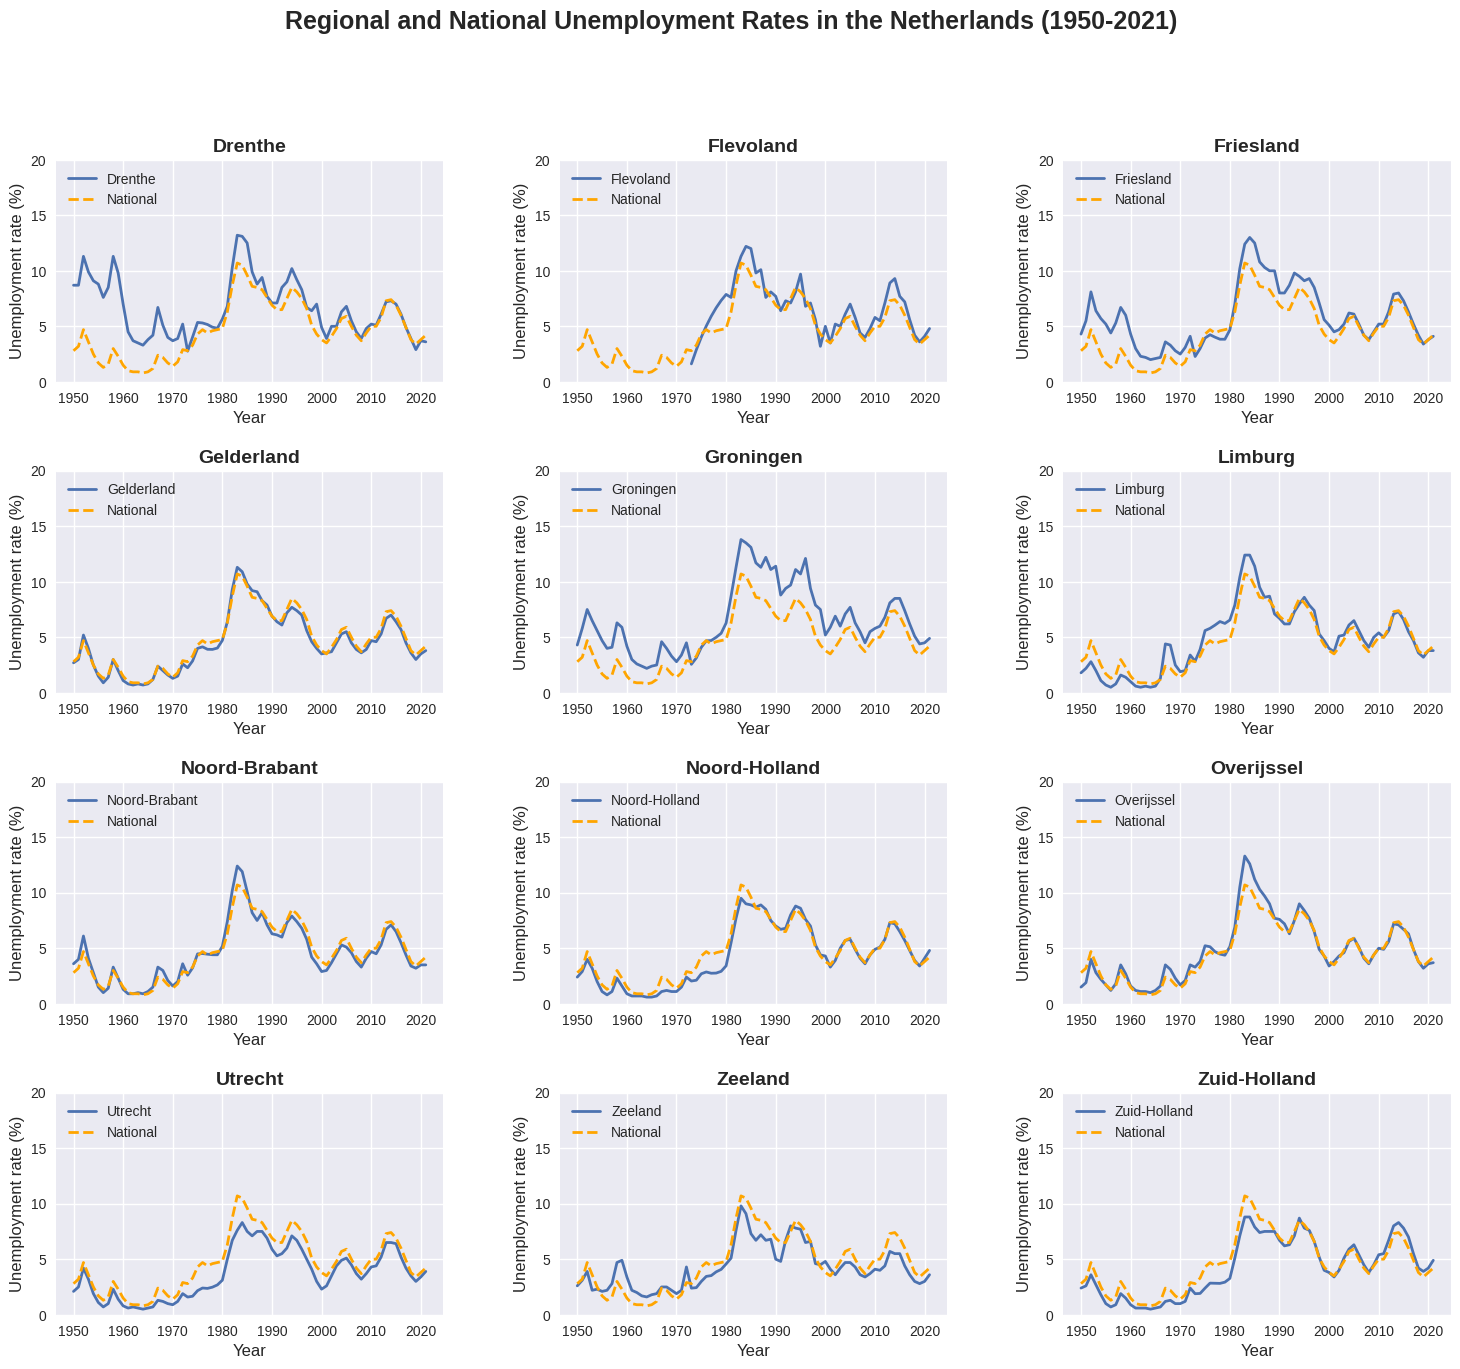

In [ ]:
# Group the data by Province
grouped = df.groupby("Province")

# Set up the plot layout
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Set the plot style
plt.style.use("seaborn")

# Loop over each group and create a plot for each one
for i, (name, group) in enumerate(grouped):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(group["Year"], group["Regiol Unemployment"], label=name, linewidth=2)
    ax.plot(group["Year"], group["National Unemployment"], label="National", linestyle="--", color="orange", linewidth=2)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Unemployment rate (%)", fontsize=12)
    ax.set_title(name, fontsize=14, fontweight="bold")
    ax.set_ylim(bottom=0, top=20)
    ax.set_xticks(range(1950, 2021, 10))
    ax.set_yticks(range(0, 21, 5))
    ax.legend(fontsize=10, loc="upper left")

# Add a suptitle
fig.suptitle("Regional and National Unemployment Rates in the Netherlands (1950-2021)", fontsize=18, fontweight="bold")

# Save the plot as a PNG file
plt.savefig("unemployment_plots.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

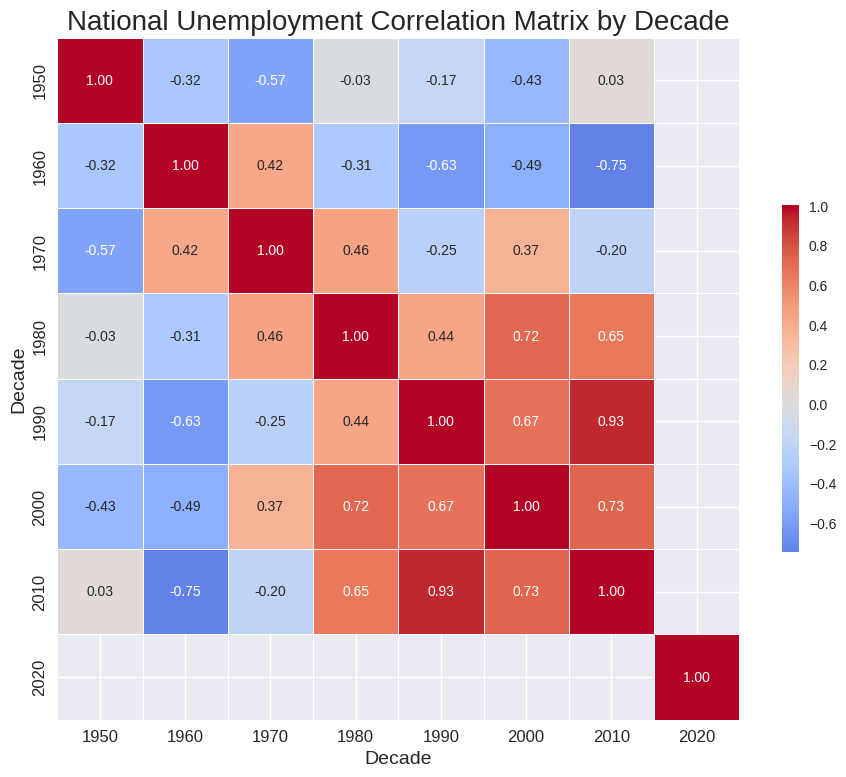

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the values in the correlation matrix to float
correlation_matrix = correlation_matrix.astype(float)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, cmap=cmap, annot=True, fmt=".2f", center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set labels for the heatmap
plt.title('National Unemployment Correlation Matrix by Decade', fontsize=20)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Decade', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the figure to a file
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')

# Show the heatmap
plt.show()


<ipython-input-389-c6689aa7728e>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


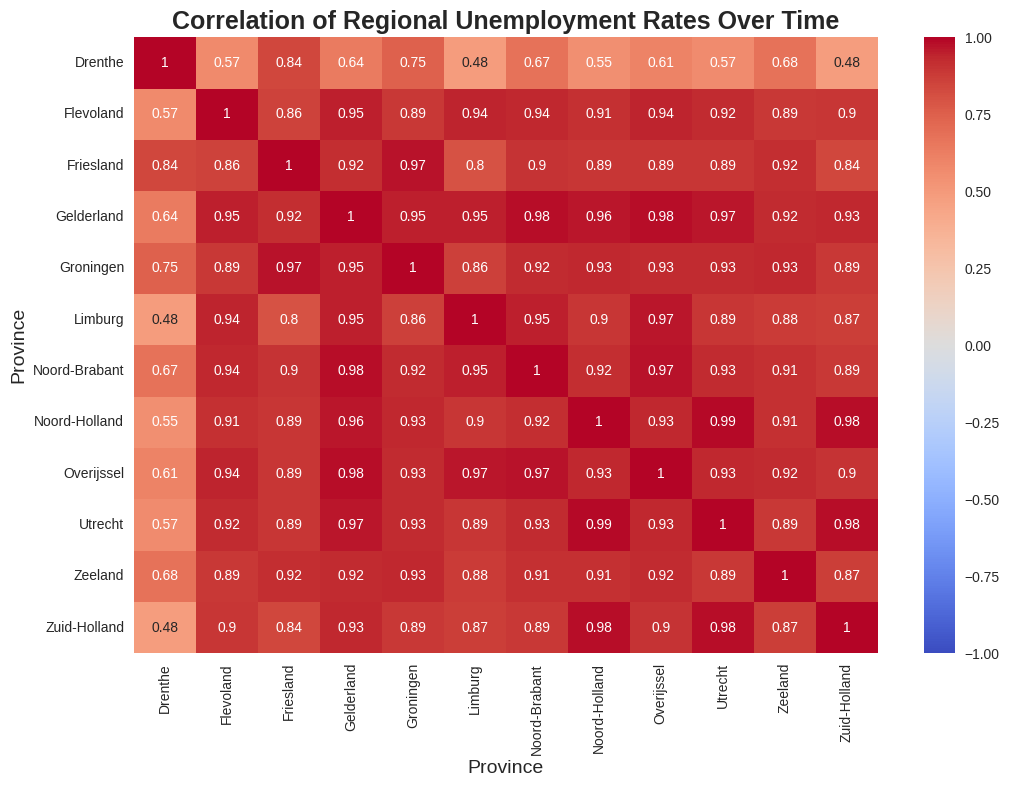

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the Excel file
df = pd.read_excel("NL_unemployment_syntetic.xlsx")

# Pivot the DataFrame to have provinces as columns and years as index
pivot_df = df.pivot_table(values='Regiol Unemployment', index='Year', columns='Province')

# Calculate the correlation between regional unemployment rates over time
correlation_matrix = pivot_df.corr()

# Set up the plot layout
plt.figure(figsize=(12, 8))

# Set the plot style
plt.style.use("seaborn")

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)

# Set plot title and labels
plt.title("Correlation of Regional Unemployment Rates Over Time", fontsize=18, fontweight="bold")
plt.xlabel("Province", fontsize=14)
plt.ylabel("Province", fontsize=14)

# Save the plot as a PNG file
plt.savefig("regional_correlation_heatmap.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


Step 2: Generate syntetic data for Flevoland for years 1950-1972 using the LSTM model


In [ ]:
!pip install -q -U keras-tuner

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, backend, constraints
from tensorflow.keras.models import Sequential
from keras_tuner import HyperModel, RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Read the Excel file
df = pd.read_excel("NL_unemployment.xlsx")

# Sort the DataFrame by year and province
df = df.sort_values(by=["Year", "Province"])

# Fill missing values in 'Regiol Unemployment' with zeros temporarily
df['Regiol Unemployment'].fillna(0, inplace=True)

# Create a new feature 'Is_Flevoland' as an indicator for Flevoland
df['Is_Flevoland'] = (df['Province'] == 'Flevoland').astype(int)

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df.drop(columns=['Province', 'Year'])),
                         columns=df.columns.drop(['Province', 'Year']))

In [ ]:
# Show the first 20 rows of the data
print(df.head(20))

         Province  Year  Regiol Unemployment  National Unemployment  \
2         Drenthe  1950                  8.7                    2.8   
4       Flevoland  1950                  0.0                    2.8   
1       Friesland  1950                  4.3                    2.8   
5      Gelderland  1950                  2.7                    2.8   
0       Groningen  1950                  4.3                    2.8   
11        Limburg  1950                  1.8                    2.8   
10  Noord-Brabant  1950                  3.6                    2.8   
7   Noord-Holland  1950                  2.4                    2.8   
3      Overijssel  1950                  1.5                    2.8   
6         Utrecht  1950                  2.1                    2.8   
9         Zeeland  1950                  2.6                    2.8   
8    Zuid-Holland  1950                  2.4                    2.8   
14        Drenthe  1951                  8.7                    3.2   
16    

In [ ]:
# Create input features and target variable for the LSTM model
X = scaled_df.drop(columns=['Regiol Unemployment']).values
y = scaled_df['Regiol Unemployment'].values

# Reshape the input features to be suitable for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Custom loss function to penalize predictions near zero
def custom_loss(y_true, y_pred):
    mse_loss = backend.mean(backend.square(y_true - y_pred))
    near_zero_penalty = backend.mean(backend.square(backend.relu(0.1 - y_pred)))
    negative_penalty = backend.mean(backend.square(backend.relu(-y_pred)))
    return mse_loss + 5000 * near_zero_penalty + 1000 * negative_penalty


# Define the HyperModel
class UnemploymentHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                              activation=hp.Choice('activation', ['relu', 'tanh']),
                              input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(layers.LeakyReLU(alpha=0.3))
        model.add(layers.Dense(1))
        model.compile(optimizer='adam', loss=custom_loss)
        return model


In [ ]:
# Perform hyperparameter optimization using keras-tuner
hypermodel = UnemploymentHyperModel()
tuner = RandomSearch(hypermodel, objective='val_loss', max_trials=10, seed=42, executions_per_trial=3)
tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [ ]:
# Retrieve the best model and train it
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=0, shuffle=False)


In [ ]:
# Make predictions using the trained model
y_pred = model.predict(X_test)

6/6 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f"Root mean squared error: {rmse}")

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae}")

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2}")

Mean squared error: 0.012192525131033168
Root mean squared error: 0.11041976784540515
Mean absolute error: 0.0807911407522799
R-squared score: 0.6537186200943255


In [ ]:
# Generate synthetic data for Flevoland (years 1950-1972)
years = np.arange(1950, 1973)
synthetic_data = []
for year in years:
    row = df.loc[(df['Province'] == 'Flevoland') & (df['Year'] == year)].drop(columns=['Province', 'Year']).values
    row_scaled = scaler.transform(row)
    X_synthetic = row_scaled[:, 1:].reshape((1, 1, 2))
    y_synthetic = model.predict(X_synthetic)
    y_synthetic_unscaled = scaler.inverse_transform(np.hstack([y_synthetic, row_scaled[:, 1:]]))[:, 0]
    synthetic_data.append(y_synthetic_unscaled[0])


1/1 [==============================] - 0s 47ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


In [ ]:
# Replace the zeros in 'Regiol Unemployment' with the generated synthetic data
df.loc[(df['Province'] == 'Flevoland') & (df['Year'] < 1973), 'Regiol Unemployment'] = synthetic_data


In [ ]:
# Show the updated DataFrame
print(df.head(20))

         Province  Year  Regiol Unemployment  National Unemployment  \
2         Drenthe  1950             8.700000                    2.8   
4       Flevoland  1950             3.239519                    2.8   
1       Friesland  1950             4.300000                    2.8   
5      Gelderland  1950             2.700000                    2.8   
0       Groningen  1950             4.300000                    2.8   
11        Limburg  1950             1.800000                    2.8   
10  Noord-Brabant  1950             3.600000                    2.8   
7   Noord-Holland  1950             2.400000                    2.8   
3      Overijssel  1950             1.500000                    2.8   
6         Utrecht  1950             2.100000                    2.8   
9         Zeeland  1950             2.600000                    2.8   
8    Zuid-Holland  1950             2.400000                    2.8   
14        Drenthe  1951             8.700000                    3.2   
16    

<ipython-input-374-5b46d90842ed>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


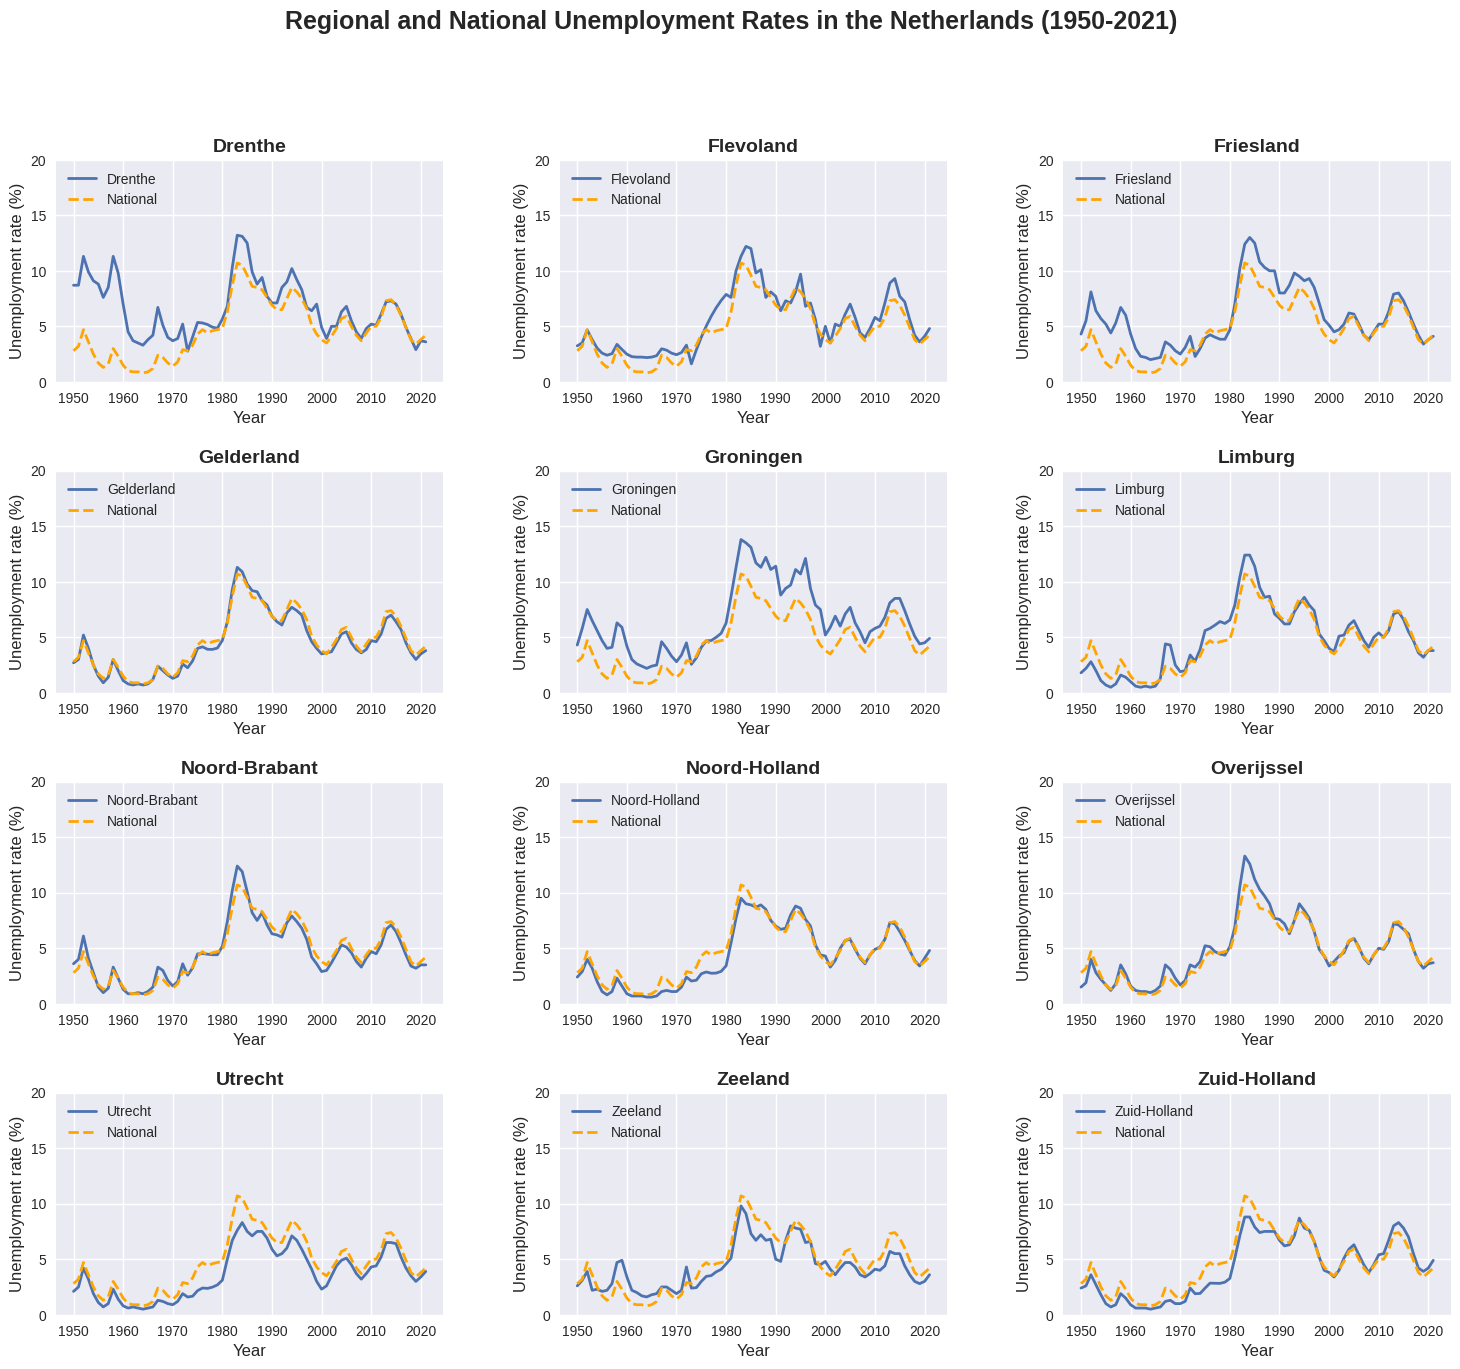

In [ ]:
# Group the data by Province
grouped = df.groupby("Province")

# Set up the plot layout
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Set the plot style
plt.style.use("seaborn")

# Loop over each group and create a plot for each one
for i, (name, group) in enumerate(grouped):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(group["Year"], group["Regiol Unemployment"], label=name, linewidth=2)
    ax.plot(group["Year"], group["National Unemployment"], label="National", linestyle="--", color="orange", linewidth=2)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Unemployment rate (%)", fontsize=12)
    ax.set_title(name, fontsize=14, fontweight="bold")
    ax.set_ylim(bottom=0, top=20)
    ax.set_xticks(range(1950, 2021, 10))
    ax.set_yticks(range(0, 21, 5))
    ax.legend(fontsize=10, loc="upper left")

# Add a suptitle
fig.suptitle("Regional and National Unemployment Rates in the Netherlands (1950-2021)", fontsize=18, fontweight="bold")

# Save the plot as a PNG file
plt.savefig("unemployment_syntetic_plots.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

<ipython-input-375-76be9435a777>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


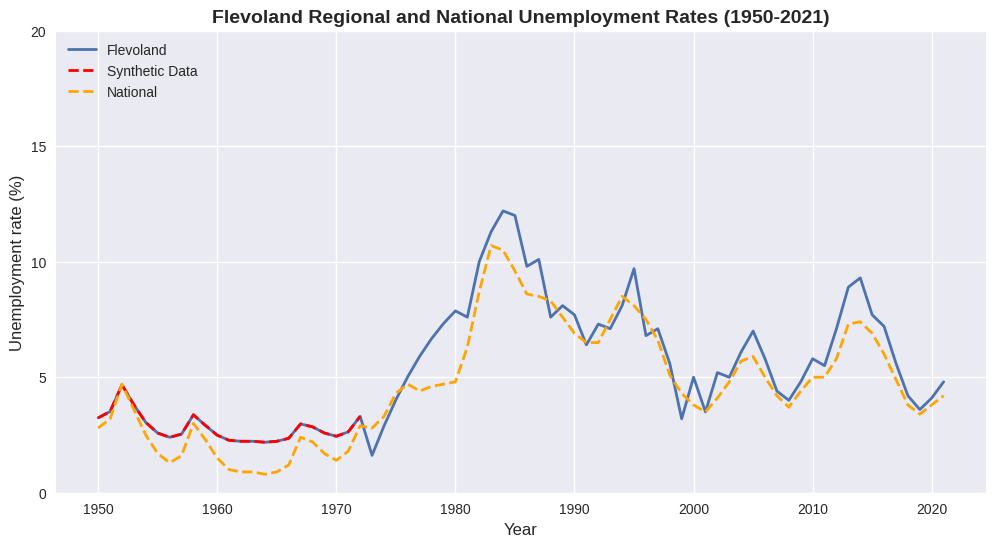

In [ ]:
# Filter the data for Flevoland
flevoland_df = df[df["Province"] == "Flevoland"]

# Set up the plot layout
fig, ax = plt.subplots(figsize=(12, 6))

# Set the plot style
plt.style.use("seaborn")

# Plot Flevoland data
ax.plot(flevoland_df["Year"], flevoland_df["Regiol Unemployment"], label="Flevoland", linewidth=2)

# Highlight the synthetic data for years 1950-1972
synthetic_data = flevoland_df[flevoland_df["Year"] < 1973]
ax.plot(synthetic_data["Year"], synthetic_data["Regiol Unemployment"], label="Synthetic Data", color="red", linewidth=2, linestyle="--")

# Plot the National Unemployment data
ax.plot(flevoland_df["Year"], flevoland_df["National Unemployment"], label="National", linestyle="--", color="orange", linewidth=2)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Unemployment rate (%)", fontsize=12)
ax.set_title("Flevoland Regional and National Unemployment Rates (1950-2021)", fontsize=14, fontweight="bold")
ax.set_ylim(bottom=0, top=20)
ax.set_xticks(range(1950, 2021, 10))
ax.set_yticks(range(0, 21, 5))
ax.legend(fontsize=10, loc="upper left")

# Save the plot as a PNG file
plt.savefig("flevoland_unemployment_syntetic_plot.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
df.to_excel("NL_unemployment_syntetic.xlsx", index=False)
